

# Project: Investigating what factors cause patients in Victoria, Brazil miss their scheduled medical appointments. 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>  The dataset holds information collected from around 100k hospital appointments in Brazil. Patients whom data is collected in this dataset are anonymous and the information captured holds the dates when appointment was originally scheduled and when the appointment had place, patient ID, appointment ID, patient's age, gender, enrollement into 'Bolsa Familia' social program, intication if patient falls under one of medical categories such as hypertension, diabetes, alcoholism, whether they are handicap and if they received an SMS reminder and if they showed up or not. The Neighbourhood column indicates where the hospital was located, not where the patient was from. 


> I posted some research questions for my analysis:
 * Are gender, age and enrollement into social program correlated with no-show appointments? 
 * Is any of the groups suffering from hypertension, diabetes, alcoholism or handicap more likely to miss their appointments?
 * Are there addictional factors that might influence the no_show rate? Perhaps the day of the appointment?
>


In [1]:
#Import the packages

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
#% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling



### General Properties

> First, I will take a look at the data to see how it looks, does it look clean, is there anything missing. 

In [2]:
#Loading data, checking the first few rows of the dataset. 

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.shape

(110527, 14)

In [4]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


I can see that there are patients with negative age, I guess this must mean that the patient hasn't been born yet and it is pregnancy appointment. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


> It seems that there are no missing values. 

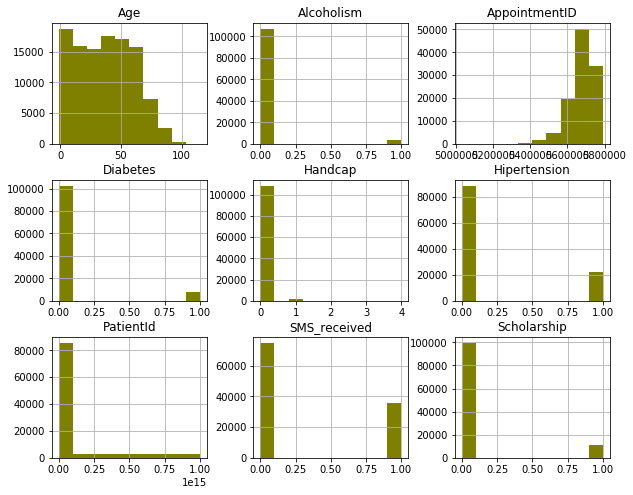

In [6]:
df.hist(figsize=(10,8), color='olive');

In [7]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

This looks interesting: there are 5 unique values for Handicap column, I might want to take a closer look at this. 



### Data Cleaning 

> I will clean the dataset to make it more readible and easier to work with. The steps I take to clean this dataset include: 

* Dropping uncertain results for Handicap column
* Dropping the columns that are not relevant for my analysis: patient ID and appointment ID
* Changing the fortmat of appointment day and the scheduled day to datetime
* Renaming the No-show column to replace '-' with '_' 
* Changing Yes and No in No_show column to 1 and 0 
* Removing rows where Handicap doesn't have value 1 or 0

In [8]:
df[(df["Handcap"] != 0) & (df["Handcap"] != 1)].head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
946,7.282582e+13,5582483,M,2016-04-14T09:26:08Z,2016-04-29T00:00:00Z,94,BELA VISTA,0,1,1,0,2,1,No
1665,1.242919e+13,5525497,M,2016-03-30T09:16:41Z,2016-04-29T00:00:00Z,64,SANTA MARTHA,0,1,0,1,2,1,No
1666,1.242919e+13,5525498,M,2016-03-30T09:16:41Z,2016-04-29T00:00:00Z,64,SANTA MARTHA,0,1,0,1,2,0,No
2071,1.242919e+13,5640120,M,2016-04-29T10:08:48Z,2016-04-29T00:00:00Z,64,SANTA MARTHA,0,1,0,1,2,0,No
2091,1.491829e+13,5638626,F,2016-04-29T08:13:59Z,2016-04-29T00:00:00Z,11,ANDORINHAS,0,0,0,0,2,0,No


In [9]:
# It looks like there are few entries where the Handicap value is 2. 

#I will leave only the rows where values are either 1 or 0. 

df = df[(df["Handcap"] == 0) | (df["Handcap"] == 1)]

In [10]:
#dropping uneccesary columns, not relevant for the analysis

df.drop(['PatientId', 'AppointmentID'], axis = 1, inplace=True)

In [11]:
#checking how the dataset looks now
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


I will change the format of ScheduledDay and AppointmentDay to datetime format for easier analysis. 


In [12]:
#Let's change the format of the ScheduledDay column and 
#replace it with ScheduledTime column
df["Scheduled_Time"] = pd.to_datetime(df.ScheduledDay, format = '%Y-%m-%dT%H:%M:%SZ')

In [13]:
#Now the same with AppointmentDay column and 
#creating AppointmentTime column

df["Appointment_Time"] = pd.to_datetime(df.AppointmentDay, format = '%Y-%m-%dT%H:%M:%SZ')

In [14]:
#checking if creation of new columns was successfull
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Time,Appointment_Time
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29 18:38:08,2016-04-29
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29 16:08:27,2016-04-29
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29 16:19:04,2016-04-29
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29 17:29:31,2016-04-29
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29 16:07:23,2016-04-29


In [15]:
#checking negative age values 

In [16]:
df[df["Age"] < 0]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Time,Appointment_Time
99832,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No,2016-06-06 08:58:13,2016-06-06


In [17]:
#Getting rid of the negative value in the age column
df = df[df["Age"] >= 0]

I will now drop the ScheduledDay and ScheduledTime columns, as we don't need them anymore. 

In [18]:
df.drop(["ScheduledDay", "AppointmentDay"], axis = 1, inplace=True)

Oops. it didn't work. It looks like I need to change it to timedelta type. 

I want to change No_show column name and to change data type into int, so I can use it for analysis later.

In [19]:
#rename the No-show column and replace '-' with '_'

df.rename(columns=lambda x: x.strip().replace("-", "_"), inplace = True)

In [20]:
#check if it worked
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,Scheduled_Time,Appointment_Time
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29 18:38:08,2016-04-29
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29 16:08:27,2016-04-29
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29 16:19:04,2016-04-29
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29 17:29:31,2016-04-29
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29 16:07:23,2016-04-29


In [21]:
#changing values into numeric
df.replace(('Yes', 'No'), (1, 0), inplace=True)

In [22]:
#check if it worked
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,Scheduled_Time,Appointment_Time
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29 18:38:08,2016-04-29
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29 16:08:27,2016-04-29
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29 16:19:04,2016-04-29
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29 17:29:31,2016-04-29
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29 16:07:23,2016-04-29


In [23]:
#Now I am converting objects into int, to use numeric values for analysis.
df['No_show'].astype(np.integer)

0         0
1         0
2         0
3         0
4         0
5         0
6         1
7         1
8         0
9         0
10        0
11        1
12        0
13        0
14        0
15        0
16        0
17        1
18        0
19        0
20        1
21        1
22        1
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
110497    0
110498    0
110499    0
110500    0
110501    0
110502    0
110503    0
110504    0
110505    0
110506    0
110507    0
110508    0
110509    0
110510    0
110511    0
110512    0
110513    0
110514    0
110515    1
110516    1
110517    0
110518    0
110519    0
110520    0
110521    0
110522    0
110523    0
110524    0
110525    0
110526    0
Name: No_show, Length: 110327, dtype: int64

Now I will check what are values for Handicap, that are not 0 or 1, as it should be accordingly to Kaggle description of the dataset.

<a id='eda'></a>
## Exploratory Data Analysis

>Now I will proceed with data analysis in regard to my research questions.

### Are gender, age and enrollement into Bolsa Familia program correlated with no-show appointments? 

First I will take a look at gender. 


In [24]:
gender_describe= df.groupby("Gender")["No_show"].describe()

print(gender_describe)

          count      mean       std  min  25%  50%  75%  max
Gender                                                      
F       71730.0  0.203095  0.402305  0.0  0.0  0.0  0.0  1.0
M       38597.0  0.199756  0.399822  0.0  0.0  0.0  0.0  1.0


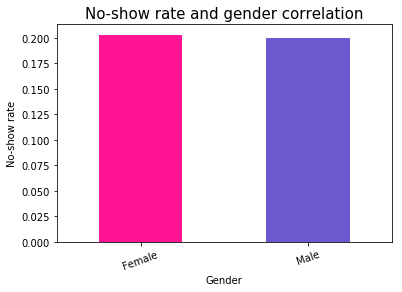

In [25]:
df.groupby("Gender")["No_show"].mean().plot.bar(color=['deeppink','slateblue'])
plt.ylabel("No-show rate")
plt.title("No-show rate and gender correlation", fontsize=15)
plt.xticks(np.arange(2), ('Female', 'Male'), rotation=20);

There are much more female patients than male patients: 
* Female: 71731
* Male: 38597

No-show ratio for genders: 
* Female: 0.20
* Male: 0.19

It seems that although the distribution of no-shows is almost even in both groups, if we consider that there are almost twice as much female patients, it seems more likely for male patients not to show up. 

###  Is there a correlation between age and the number of no-show appointments? 

In [26]:
#I will start with looking at the average age of show and no-show
#creating masks for no-show and show appointments

showed = df.No_show == 0
notshowed = df.No_show == 1

In [27]:
#average age of showed up patients
df.Age[showed].mean()


37.77709002941544

In [28]:
# average age of no-show patients
df.Age[notshowed].mean()


34.27910943531735

The average age for a no-show patient is **34** years old and for a patient that shows up is **37**. This observation is very interesting as those are quite close age categories. To explore this trend better I will now check the age distribution and number of patients who showed up and who didn't. 

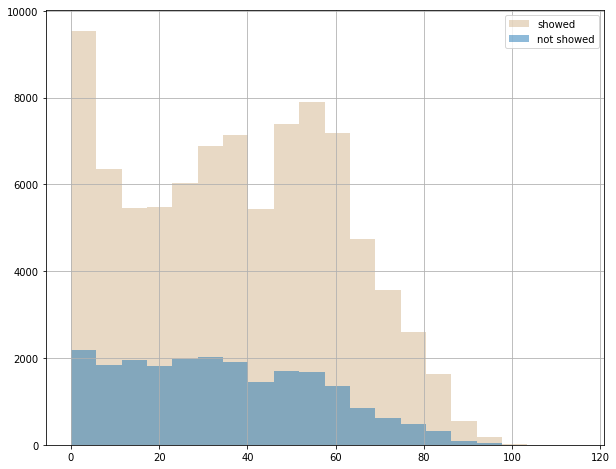

In [29]:
#Plotting age with the show/no show appointments.
df.Age[showed].hist(alpha=0.5, bins=20, label='showed', color='tan', figsize=(10,8))
df.Age[notshowed].hist(alpha= 0.5, bins=20,label='not showed');

plt.legend();

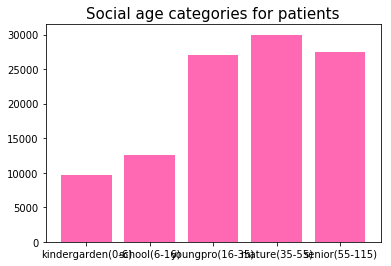

In [30]:
#I will use the method I learned in Udacity 
#study case and I will slice the data into groups

a_edges = [ 0, 6, 16, 35, 55, 115]
a_labels = ["kindergarden(0-6)", "school(6-16)", "youngpro(16-35)", "mature(35-55)", "senior(55-115)"]

# I will add a new column to hold the age group information

df["age_group"] = pd.cut(df["Age"], a_edges, labels = a_labels)
plt.bar([1,2,3,4,5], df["age_group"].value_counts()[a_labels], tick_label = a_labels, color='hotpink'); 
plt.title("Social age categories for patients", fontsize=15);

The total age group proportion of patients can be described as follows:
* Majority of patients are between 35-55 years old. 
* The next largest group is yourng professionals between 16-35 years old. 
* Third largest group is between 55-115 years old. 

In [31]:
df.age_group[showed].describe()

count             85149
unique                5
top       mature(35-55)
freq              24071
Name: age_group, dtype: object

Patients falling into **mature** group are the largest group of patients **showing up** for their appointments. Patients in his group are between 35-55 years old, so they are most likely having theit own families and are working full time. This is an interesting observation, as it could be easily assumed that those patients are rather bussy with their lives and it might be gard for them to show up for an appointment. 

In [32]:
df.age_group[notshowed].describe()

count               21639
unique                  5
top       youngpro(16-35)
freq                 6493
Name: age_group, dtype: object

The largest group most often **failing to showing up** for their appointments falls into category of **young professionals**, between 16 and 35. Those are students and young people entering the workplace, also probably the people who are having young children or planning a family. 

In [33]:
age_df = df.groupby("age_group")["No_show"].describe()
print(age_df)

                     count      mean       std  min  25%  50%  75%  max
age_group                                                              
kindergarden(0-6)   9709.0  0.191781  0.393722  0.0  0.0  0.0  0.0  1.0
school(6-16)       12586.0  0.245749  0.430548  0.0  0.0  0.0  0.0  1.0
youngpro(16-35)    27088.0  0.239700  0.426908  0.0  0.0  0.0  0.0  1.0
mature(35-55)      29979.0  0.197071  0.397793  0.0  0.0  0.0  0.0  1.0
senior(55-115)     27426.0  0.156166  0.363019  0.0  0.0  0.0  0.0  1.0


Looking at the mean values for each category it seems that school age patients have the highest no-show rate of **0.24**. 
The next highest no-show rate group is young professionals with rate of **0.23**. 
The most reliable are senior patients, who are least likely to miss their appointments. Their missed appointments rate is **0.15**.

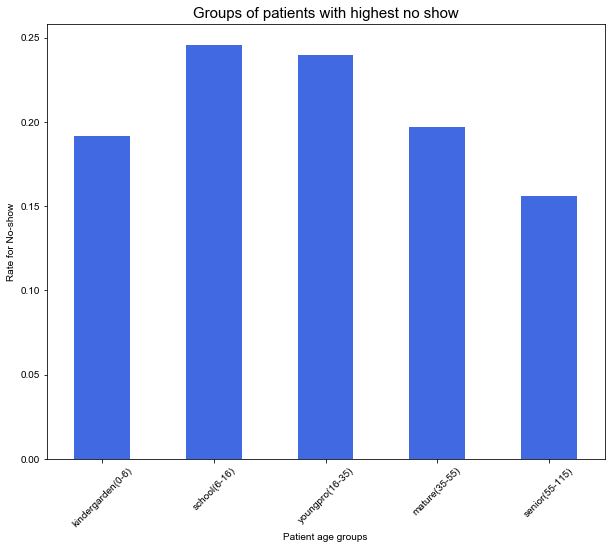

In [34]:
#I will plot this data with bar plot to visualise it better
fig0=df.groupby("age_group")["No_show"].mean().plot(kind='bar', color='royalblue', figsize=(10,8))
fig0.set_xticklabels(fig0.get_xticklabels(), rotation=45)
plt.style.use('seaborn')
plt.ylabel("Rate for No-show")
plt.xlabel("Patient age groups")
plt.title("Groups of patients with highest no show", fontsize=15);

### Does the social sholarship impact no-show appointments rate?

Now I will check the enrollement into social scholarship program and its correlation with the no-show appointments. 

In [35]:
scholarship = df.groupby("Scholarship")["No_show"].describe()
print(scholarship)

               count      mean       std  min  25%  50%  75%  max
Scholarship                                                      
0            99484.0  0.198032  0.398518  0.0  0.0  0.0  0.0  1.0
1            10843.0  0.237665  0.425672  0.0  0.0  0.0  0.0  1.0


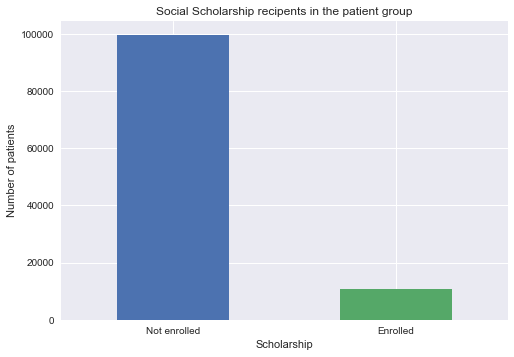

In [36]:

fig2=df.groupby("Scholarship")["No_show"].count().plot.bar()
plt.ylabel("Number of patients")
plt.title("Social Scholarship recipents in the patient group")
plt.xticks(np.arange(2), ('Not enrolled', 'Enrolled'), rotation=0);


Majority of patients is not enrolled into social scholarship program. Next, I will check the age distribution among patients who are enrolled in the social scholarship program. 

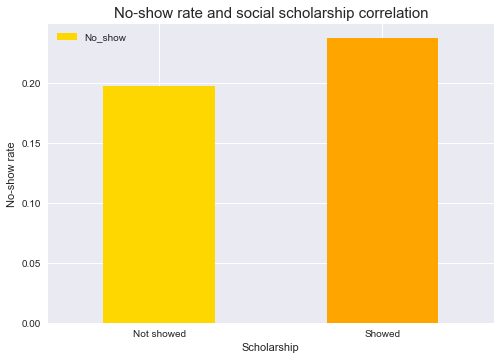

In [37]:

df.groupby("Scholarship")["No_show"].mean().plot.bar(color=['gold','orange'])
plt.ylabel("No-show rate")
plt.title("No-show rate and social scholarship correlation", fontsize=15)
plt.xticks(np.arange(2), ('Not showed', 'Showed'), rotation=0)
plt.legend();

In [38]:
#Checking correlation between age and scholarship
sch_age=df.groupby("age_group")["Scholarship"].describe()
print(sch_age);

                     count      mean       std  min  25%  50%  75%  max
age_group                                                              
kindergarden(0-6)   9709.0  0.100422  0.300578  0.0  0.0  0.0  0.0  1.0
school(6-16)       12586.0  0.143016  0.350103  0.0  0.0  0.0  0.0  1.0
youngpro(16-35)    27088.0  0.132974  0.339553  0.0  0.0  0.0  0.0  1.0
mature(35-55)      29979.0  0.114880  0.318883  0.0  0.0  0.0  0.0  1.0
senior(55-115)     27426.0  0.035368  0.184711  0.0  0.0  0.0  0.0  1.0


It seems that among the recipents of social scholarship, school age patients have highest no-show rate of **0.14**. 
Young professionals who receive social scholarship are also quite likely to miss their appointment and their no-show rate is at **0.13**. Third largest group are mature patients between 35 and 55 years old, and the rate for this group is at **0.11**. 

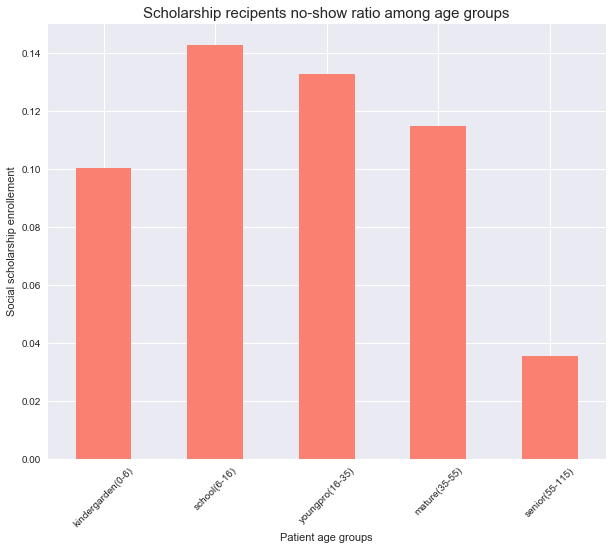

In [39]:
#To see the relation between age and scholarship better, let's plot a bar chart 
#with mean value for no-shows appointment among social scholarship recipents

fig1=df.groupby("age_group")["Scholarship"].mean().plot(kind='bar',color='salmon', figsize=(10,8));
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)
plt.ylabel("Social scholarship enrollement")
plt.xlabel("Patient age groups")
plt.title("Scholarship recipents no-show ratio among age groups", fontsize=15);

From the analysis above it appears that majority of patients who missed their appointments and are enrolled into social scholarship progam fall into school age patients (6-16 years old). 

It seems that younger patients are more often enrolled in the sholarship program. The school age patients and young profesionals are more likely to be receiving social sholarship. This are also the same age groups of patients who are more likely to miss their appointments in general. 

## Is any of the groups suffering from hypertension, diabetes, alcoholism or handicap more likely to miss their appointments?

Now, I will move to investigating the health factors that might show correlation with no-show rate. 

#### Are handicapped patients having higher no-show rate?

In [40]:
handicap_summary = df.groupby("Handcap")["No_show"].describe()
print(handicap_summary)

            count      mean       std  min  25%  50%  75%  max
Handcap                                                       
0        108285.0  0.202355  0.401757  0.0  0.0  0.0  0.0  1.0
1          2042.0  0.179236  0.383644  0.0  0.0  0.0  0.0  1.0


Only a small part of all patients falls into handicap category. Approximately 2% of patients is handicaped. 

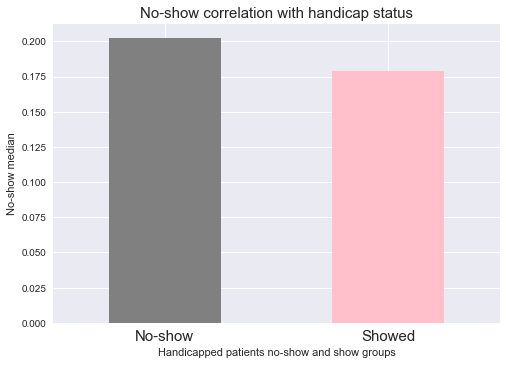

In [41]:
df.groupby("Handcap")["No_show"].mean().plot(kind='bar', color=['grey','pink'])
plt.style.use('seaborn-ticks')
plt.ylabel("No-show median")
plt.xlabel('Handicapped patients no-show and show groups')
plt.xticks(np.arange(2), ('No-show', 'Showed'), rotation=0, fontsize=15)
plt.title("No-show correlation with handicap status", fontsize=15);

In [42]:
#Now I will plot a bar chart to check the no-show ratio for handicap sufferers 
#handicap_means = handicap_summary.iloc[:2, 1]
#handicap_counts = handicap_summary.iloc[:2, 0]
#handicap_labels = ["No", "Yes"]
#plt.bar([1,2], handicap_summary.iloc[:2, 1], tick_label = handicap_labels, color='khaki');
#plt.ylabel("No-show median")
#plt.xlabel("Is patient handicapped?")
#plt.title("No-show correlation with handicap status");

Although patients suffering from handicap are only 2% of the total number of patients, the rate for no-show appointments seems to be closely related with handicap status.  

#### Medical conditions

Next, I will take a look at each medical condition breakdown

### Are patients with hypertension are more likely to miss their appointmnts? 

In [43]:
hypertension_summary = df.groupby("Hipertension")["No_show"].describe()

print(hypertension_summary)

                count      mean       std  min  25%  50%  75%  max
Hipertension                                                      
0             88611.0  0.209116  0.406680  0.0  0.0  0.0  0.0  1.0
1             21716.0  0.172592  0.377903  0.0  0.0  0.0  0.0  1.0


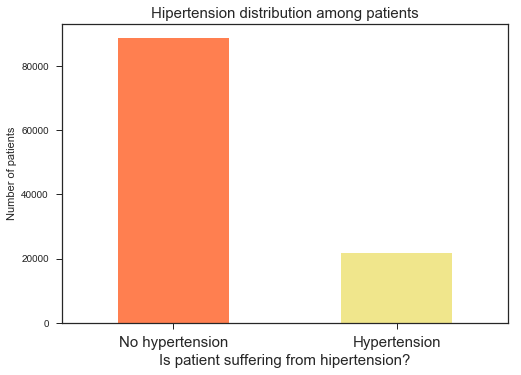

In [44]:
df.groupby("Hipertension")["No_show"].count().plot(kind='bar',color=['coral','khaki'])
plt.style.use('seaborn-notebook')
plt.ylabel("Number of patients")
plt.xlabel("Is patient suffering from hipertension?", fontsize=15)
plt.xticks(np.arange(2), ('No hypertension', 'Hypertension'), rotation=0, fontsize=15)
plt.title("Hipertension distribution among patients", fontsize=15);

It looks like approximately 1/5 of all patients suffer from hypertension. 

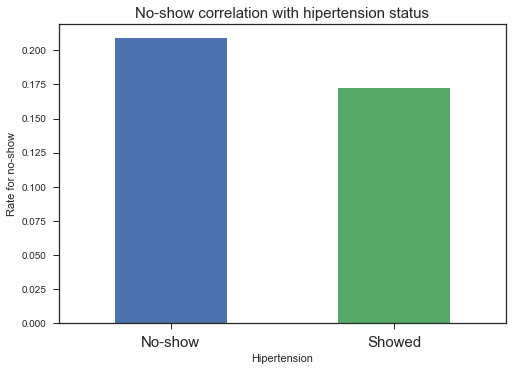

In [45]:

df.groupby("Hipertension")["No_show"].mean().plot(kind='bar')
plt.ylabel("Rate for no-show")
plt.xticks(np.arange(2), ('No-show', 'Showed'), rotation=0, fontsize=15)
plt.title("No-show correlation with hipertension status", fontsize=15);


It seems that patients suffering from hypertension are more reliable and they are less likely to miss their appointments than other patients. Hypertension patient's no-show rate is **0.17** when overall rate for patients without hypertension is **0.20**.


### Are patients suffering from diabetes are more likely to miss their appointmnts? 

In [46]:
diabetes_summary = df.groupby("Diabetes")["No_show"].describe()

print(diabetes_summary)

             count      mean       std  min  25%  50%  75%  max
Diabetes                                                       
0         102427.0  0.203618  0.402690  0.0  0.0  0.0  0.0  1.0
1           7900.0  0.180000  0.384212  0.0  0.0  0.0  0.0  1.0


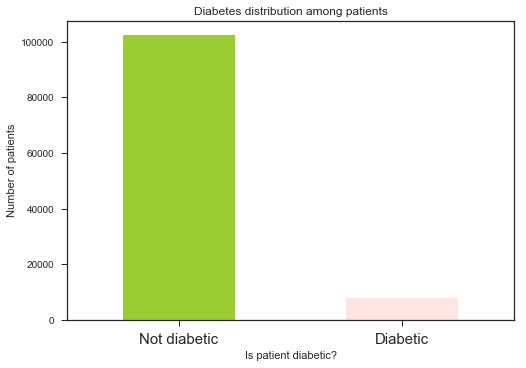

In [47]:
df.groupby("Diabetes")["No_show"].count().plot(kind='bar', color=['yellowgreen', 'mistyrose'])
plt.ylabel("Number of patients")
plt.xlabel("Is patient diabetic?")
plt.xticks(np.arange(2), ('Not diabetic', 'Diabetic'), rotation=0, fontsize=15)
plt.title("Diabetes distribution among patients");

Diabetes affected approximately 8k patients from the total 100k. Diabetes is a small part of diagnosis in the patient group ant only approximately 8% of patients are diagnosed with this medical condition. 

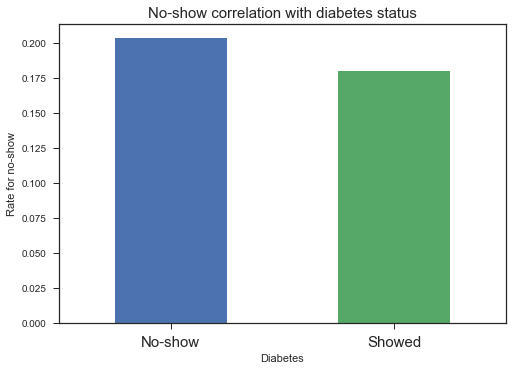

In [48]:
df.groupby("Diabetes")["No_show"].mean().plot(kind='bar')
plt.ylabel("Rate for no-show")
plt.xticks(np.arange(2), ('No-show', 'Showed'), rotation=0, fontsize=15)
plt.title("No-show correlation with diabetes status", fontsize=15);


Among patients suffering from diabetes no-show rate is at **0.18** and it is lower than the rate for patients not diagnosed with diabetis, which is **0.20**. 

### Are patients suffering from alcoholism are more likely to miss their appointmnts?

In [49]:
alcohol_summary = df.groupby("Alcoholism")["No_show"].describe()

print(alcohol_summary)

               count      mean       std  min  25%  50%  75%  max
Alcoholism                                                       
0           106975.0  0.201944  0.401453  0.0  0.0  0.0  0.0  1.0
1             3352.0  0.201372  0.401085  0.0  0.0  0.0  0.0  1.0


Alcoholism is even smaller fraction than diabetes and approximately 3% of all patients suffer from alcoholism. 

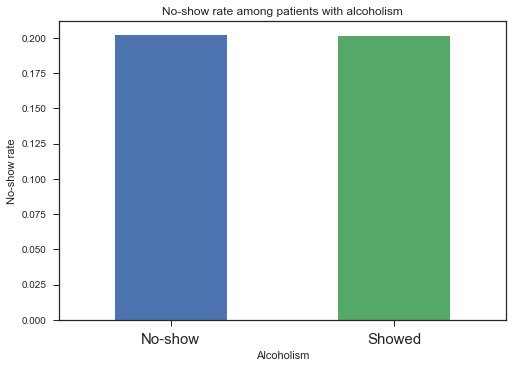

In [50]:


df.groupby("Alcoholism")["No_show"].mean().plot(kind='bar')
plt.ylabel("No-show rate")
plt.xlabel("Alcoholism")
plt.xticks(np.arange(2), ('No-show', 'Showed'), rotation=0, fontsize=15)
plt.title("No-show rate among patients with alcoholism");



The rate for patients suffering from alcoholism is almost identical to the average no-show rate. Both rates are at **0.20**. 



From the above analysis I am councluding that none of the medical conditions is associated with higher no-show rate.It seems that patients suffering from the above conditions are more reliable than average patients and their condition is not correlated with missing appointments.

#### Is SMS notification helpful with preventing patients from missing their appointments?

In [51]:
#First I will look at the amount of patients who received sms notifications
SMS_summary = df.groupby("SMS_received")["No_show"].describe()
print(SMS_summary)

                count      mean       std  min  25%  50%  75%  max
SMS_received                                                      
0             74892.0  0.166947  0.372931  0.0  0.0  0.0  0.0  1.0
1             35435.0  0.275857  0.446952  0.0  0.0  0.0  1.0  1.0


It seems that patients who received text messages are around 33% of all the patients. 

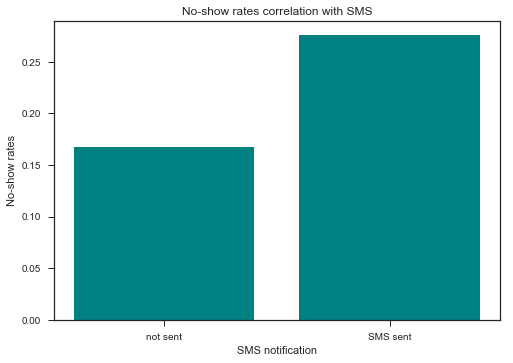

In [52]:
SMS_means = SMS_summary.iloc[:2, 1]
SMS_counts = SMS_summary.iloc[:2, 0]
SMS_labels = ["not sent", "SMS sent"]
plt.bar([1,2], SMS_summary.iloc[:2, 1], tick_label = SMS_labels, color='teal');
plt.ylabel("No-show rates")
plt.xlabel("SMS notification")
plt.title("No-show rates correlation with SMS");

Patients who received SMS notification are more likely to miss their appointments, so sending text messages seems to be not effective in fixing the no-show rate. 

### Is weekday of the appointment correlated with the no-show rate?

In [53]:
#I will now create a new column that extracts day of the week from date
df['WeekDay_of_appointment'] = pd.to_datetime(df['Appointment_Time']).apply(lambda x: x.isoweekday())
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,Scheduled_Time,Appointment_Time,age_group,WeekDay_of_appointment
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29 18:38:08,2016-04-29,senior(55-115),5
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29 16:08:27,2016-04-29,senior(55-115),5
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29 16:19:04,2016-04-29,senior(55-115),5
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29 17:29:31,2016-04-29,school(6-16),5
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29 16:07:23,2016-04-29,senior(55-115),5


In [54]:
#I used stackoverfow to apply this method
daysnames = df.Appointment_Time.dt.weekday.astype(int)
def weekd(dayNumber):
    names_days = []
    days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    for d in dayNumber:
        names_days.append(days[d])
    return(names_days)

In [55]:
appointment_days = weekd(daysnames)
df["WeekDay_of_appointment"] = appointment_days
weekday_describe = df.groupby("WeekDay_of_appointment")["No_show"].describe()
print(weekday_describe);

                          count      mean       std  min  25%  50%  75%  max
WeekDay_of_appointment                                                      
Friday                  18985.0  0.212431  0.409039  0.0  0.0  0.0  0.0  1.0
Monday                  22678.0  0.206412  0.404738  0.0  0.0  0.0  0.0  1.0
Saturday                   39.0  0.230769  0.426833  0.0  0.0  0.0  0.0  1.0
Thursday                17217.0  0.193704  0.395211  0.0  0.0  0.0  0.0  1.0
Tuesday                 25584.0  0.200750  0.400570  0.0  0.0  0.0  0.0  1.0
Wednesday               25824.0  0.196871  0.397642  0.0  0.0  0.0  0.0  1.0


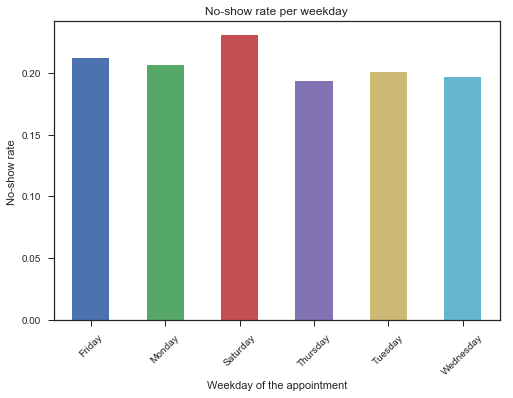

In [56]:
fig7=df.groupby("WeekDay_of_appointment")["No_show"].mean().plot(kind='bar')
fig7.set_xticklabels(fig7.get_xticklabels(), rotation=45)
plt.ylabel("No-show rate ")
plt.xlabel("Weekday of the appointment")
plt.title("No-show rate per weekday");

The day of the appointment has no significant correlation with no-show rate. There are some variations and Thursday seems to have lowest no-show rate when Friday and Saturday have the highest.

In [57]:
#checking if worked
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,Scheduled_Time,Appointment_Time,age_group,WeekDay_of_appointment
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29 18:38:08,2016-04-29,senior(55-115),Friday
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29 16:08:27,2016-04-29,senior(55-115),Friday
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29 16:19:04,2016-04-29,senior(55-115),Friday
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29 17:29:31,2016-04-29,school(6-16),Friday
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29 16:07:23,2016-04-29,senior(55-115),Friday


In [58]:
df["ScheduleTime"] = pd.to_datetime(df.Scheduled_Time, format = '%Y-%m-%dT%H:%M:%SZ')
day_difference = (df.Appointment_Time.dt.date - df.ScheduleTime.dt.date)
day_difference = day_difference.astype('timedelta64[D]')
df["days_before_appointment"] = day_difference
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,Scheduled_Time,Appointment_Time,age_group,WeekDay_of_appointment,ScheduleTime,days_before_appointment
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29 18:38:08,2016-04-29,senior(55-115),Friday,2016-04-29 18:38:08,0.0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29 16:08:27,2016-04-29,senior(55-115),Friday,2016-04-29 16:08:27,0.0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29 16:19:04,2016-04-29,senior(55-115),Friday,2016-04-29 16:19:04,0.0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29 17:29:31,2016-04-29,school(6-16),Friday,2016-04-29 17:29:31,0.0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29 16:07:23,2016-04-29,senior(55-115),Friday,2016-04-29 16:07:23,0.0


In [59]:
df[day_difference < 0]

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,Scheduled_Time,Appointment_Time,age_group,WeekDay_of_appointment,ScheduleTime,days_before_appointment
27033,M,38,RESISTÊNCIA,0,0,0,0,1,0,1,2016-05-10 10:51:53,2016-05-09,mature(35-55),Monday,2016-05-10 10:51:53,-1.0
55226,F,19,SANTO ANTÔNIO,0,0,0,0,1,0,1,2016-05-18 14:50:41,2016-05-17,youngpro(16-35),Tuesday,2016-05-18 14:50:41,-1.0
64175,F,22,CONSOLAÇÃO,0,0,0,0,0,0,1,2016-05-05 13:43:58,2016-05-04,youngpro(16-35),Wednesday,2016-05-05 13:43:58,-1.0
71533,F,81,SANTO ANTÔNIO,0,0,0,0,0,0,1,2016-05-11 13:49:20,2016-05-05,senior(55-115),Thursday,2016-05-11 13:49:20,-6.0
72362,M,7,TABUAZEIRO,0,0,0,0,0,0,1,2016-05-04 06:50:57,2016-05-03,school(6-16),Tuesday,2016-05-04 06:50:57,-1.0


In [60]:
df = df[day_difference >=0]

In [61]:
df["days_before_appointment"].describe()

count    110322.000000
mean         10.187524
std          15.257955
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: days_before_appointment, dtype: float64

Average waiting time for the appointment is 10 days and maximum 179 days. Half of the appointments takes place 4 days from scheduling. 

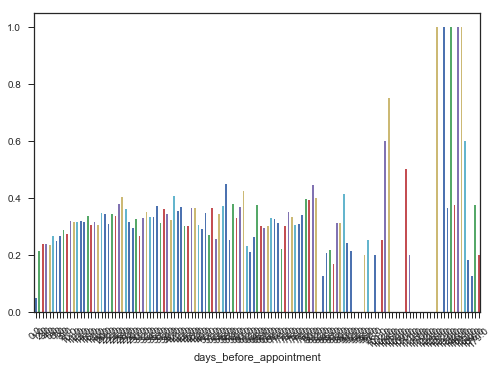

In [62]:
fig8=df.groupby("days_before_appointment")["No_show"].mean().plot(kind='bar')
fig8.set_xticklabels(fig8.get_xticklabels(), rotation=45);

This seems a little messy. I will create the categories for time between the day when appointment was scheduled and the appointment day, to better show waiting time for the appointment.

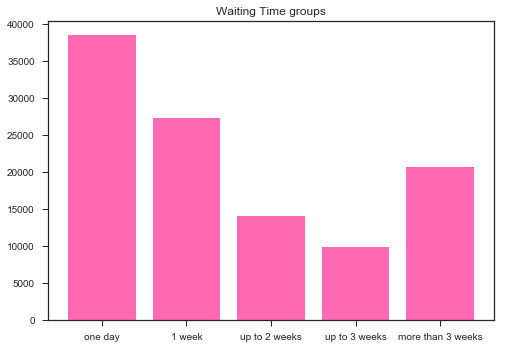

In [63]:
#I will create groups for the waiting time
bin_edges = [0, 1, 7, 14, 21, 180]
bin_labels =["one day", "1 week", "up to 2 weeks", "up to 3 weeks", "more than 3 weeks"]
#plotting with bar chart
df["waiting_time"] = pd.cut(df["days_before_appointment"], bin_edges, labels = bin_labels, right = False, include_lowest = True)
plt.bar([1,2,3,4,5], df["waiting_time"].value_counts()[bin_labels], tick_label = bin_labels, color='hotpink') 
plt.title("Waiting Time groups");

Majority of the appointments happens to be at the same day as they were scheduled ow within one week from scheduling.

In [64]:
waiting_time_dsc = df.groupby("waiting_time")["No_show"].describe()
print(waiting_time_dsc)

                     count      mean       std  min  25%  50%  75%  max
waiting_time                                                           
one day            38485.0  0.046460  0.210481  0.0  0.0  0.0  0.0  1.0
1 week             27219.0  0.236820  0.425139  0.0  0.0  0.0  0.0  1.0
up to 2 weeks      14006.0  0.289804  0.453688  0.0  0.0  0.0  1.0  1.0
up to 3 weeks       9904.0  0.322193  0.467340  0.0  0.0  0.0  1.0  1.0
more than 3 weeks  20708.0  0.327844  0.469439  0.0  0.0  0.0  1.0  1.0


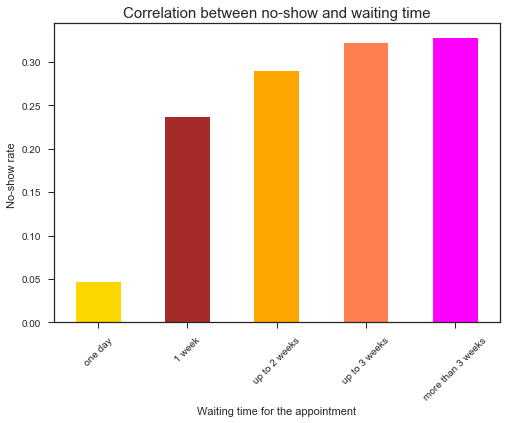

In [65]:
#plotting bar chart to explore no-show and waiting time
plt.style.use('seaborn-ticks')
fig9=df.groupby("waiting_time")["No_show"].mean().plot(kind='bar', color=('gold', 'brown','orange','coral', 'fuchsia'))

fig9.set_xticklabels(fig9.get_xticklabels(), rotation=45)
plt.ylabel("No-show rate ")
plt.xlabel("Waiting time for the appointment")
plt.title("Correlation between no-show and waiting time", fontsize=15);

The rate for no-show appointments is raising with the waiting time for the appointment. 
* one day waiting rate **0.04**
* one week waiting rate **0.23**
* 2 weeks waiting rate **0.28**
* 3 weeks waiting rate **0.32**
* more than 3 weeks rate **0.32**



<a id='conclusions'></a>
## Conclusions



**1. Are gender, age and enrollement into Bolsa Familia program correlated with no-show appointments?**

* No show median is very similar for both male and female patients. It seems that although the distribution of no-shows is almost even in both groups, if we consider that there are almost twice as much female patients, it seems more likely for male patients not to show up.
* Younger patients are more likely to miss their appointments: school children and young adults have higher no-show median. this could be linked with school schedule and work obligatories of young adults. Perhaps it is harder for those groups to find a time to make their way to the clinic. Also, those groups might be either using public transport or be dependent on their parents to drive them, which might cause them missing their appointments. 
* The same groups: school children and young adults are most often enrolled into social sholarship program. Although, the social sholarship seems not to be correlated directly with no-show appointments. 

**2. Is any of the groups suffering from hypertension, diabetes, alcoholism or handicap more likely to miss their appointments?**

* None of the medical conditions seems to have an impact on the higher no show rate.
* However, handicap patients have higher no-show rate than patients suffering from other medical conditions. This might be correlated with the  dependency of those patients on their carers, but also they require specially adjusted infracture and means of transportation.  
* SMS notification system is not preventing patients from missing their appointments. 

**3. Is weekday of the appointment correlated with the no-show rate?**

* The weekdays on which appointment falls seems not to be clearly correlated with the no-show ratio. Thursday has slightly lower no-show rate than other weekndays, when Friday and Saturday are more likely to be the days when appointment is missed. Perhaps this is correlated with weekend plans like school trips, camps, visiting family or other duties. 
* **Waiting time** however, shows strong correlation with the no-show rate. The longer waiting time the more probable that the patient will miss the scheduled appointment. 

## Recommendation 

It might be worth investigating further the following issues:
* Were the text messages 'sent' or 'received'? Perhaps there is a technica l issue preventing patients from receiving SMS notifications?
* What is the  distance from the clinic that patients have to travel? Is the public transport in Brasil well designed? 
* How the appointments are scheduled? Can patients choose their own timeslot online? Or is it chosen for them? Having an online appointment scheduling system could help to reduce no-show rates by giving patients more flexibility. 
* If the appointments scheduled during the daytime can school children or young adults leave school/workplace to attend the appointment without inconviniences? 


## Limitations

* The description of the data set is a bit inconsistent: accordingly to Kaggle there is approximately 300k entries in the dataset, when actually there is only 100k 
* Socio-cultural background needed. I think knowing the socio-cultural situation in Brazil would help better investigate this dataset 
* Distance from the hospital/clinic and means of transportation could be very helpful in understanding the trends in this dataset
* There are no missing values 
* Some values had to be removed: negative age or days from scheduled appointment, but in general data was quite clean 
* More information on the SMS reminders is needed in order to investigate this feature (when SMS was sent? was it received? is database of phone numbers up t date?)

I hope my research helps to provide some meaningful insight on the issue. 



In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigating no-show appointments in Brazil(Adriana2).ipynb'])

0